In [76]:
# general
# import pyarrow.parquet as pq
import pandas as pd
# from scipy import stats
# import random
# from pandasql import sqldf
import duckdb
from sklearn.pipeline import Pipeline
import joblib
import fastparquet
import os
import tqdm
import numpy as np
# from tqdm.notebook import tqdm as inplus

# scoring
# from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer

# drawing
# import seaborn as sns
# import matplotlib.pyplot as plt


# transform
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import MinMaxScaler


# estimators
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
# import lightgbm as lgb


# # spark
# import findspark
# findspark.init()
# import pyspark
# from pyspark.sql import SparkSession
# from IPython.core.display import HTML
# display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
def sample_df(df3, total_rows =  100000, neg_percent = 50, pos_percent = 50):
#     print( 'sample_df3 start')
    df3_pos = df3[df3['flag'] == 1].sample(int(total_rows / 100 * pos_percent))
    df3_neg = df3[df3['flag'] == 0].sample(int(total_rows / 100 * neg_percent))
    df3_pos = df3_pos.reset_index()
    df3_neg = df3_neg.reset_index()
    df3_pos = df3_pos.drop('index', axis=1)
    df3_neg = df3_neg.drop('index', axis=1)
    df3 = pd.concat([df3_pos, df3_neg])
    
#     print( 'sample_df3 end')
#     print('-')      
#     print('-')      
    #print('-') 
    
    return df3

In [3]:
def mean(lst): 
    return sum(lst) / len(lst) 

In [4]:
def overdue_and_quick_closure_duck(df_time_exp):
    
    
    con = duckdb.connect(':memory:')
    
    # new column, product-wise
    df_time_exp['closed_faster_than_expected'] = df_time_exp['pre_fterm'] < df_time_exp['pre_pterm'] 
    df_time_exp['closed_faster_than_expected'] = df_time_exp['closed_faster_than_expected'].apply(lambda x: int(x))

    # new column, product-wise
    df_time_exp['overdue_severity'] = df_time_exp['is_zero_loans5'] + df_time_exp['is_zero_loans530']*2 + df_time_exp['is_zero_loans3060']*3 + df_time_exp['is_zero_loans6090']*4 + df_time_exp['is_zero_loans90']*5
    
    # two new columns, client-wise, ready for aggregation
    result = con.execute('''
    SELECT id, 
    cast(SUM(overdue_severity) as float) / max(rn) AS prone_to_overdue, 
    cast(SUM(closed_faster_than_expected) as float) / max(rn) as prone_to_close_faster
    FROM df_time_exp
    GROUP BY id
    '''
                        ).fetchall()

    result = pd.DataFrame.from_records(result, columns=['id','prone_to_overdue', 'prone_to_close_faster'])
    df_time_exp = pd.merge(result, df_time_exp, on='id', how='left')
    return df_time_exp

In [5]:
def credit_status_prevalent_atm(df):
    # new column, client-wise, ready for aggregation
    con = duckdb.connect(':memory:')

    con.register('df', df)

    result = con.execute(f'''
    SELECT id, 
    mode(enc_loans_credit_status) as credit_status_prevalent_atm, 
    FROM df
    GROUP BY id
    '''
    ).fetchall()

    result = pd.DataFrame.from_records(result, columns=['id', 'credit_status_prevalent_atm'])
    df = pd.merge(df, result, on='id', how='left')

    return df

In [6]:
def credit_status_general_mean(df):
    # new column, client-wise, ready for aggregation
    con = duckdb.connect(':memory:')

    con.register('df', df)

    result = con.execute(f'''
    SELECT id,  
    cast(sum(enc_loans_credit_status) as float) / max(rn) as credit_status_general_mean
    FROM df
    GROUP BY id
    '''
    ).fetchall()


    result = pd.DataFrame.from_records(result, columns=['id','credit_status_general_mean'])
    df = pd.merge(df, result, on='id', how='left')

    return df

In [7]:
def credit_line_length(df):
    # new column, client-wise, ready for aggregation
    
    con = duckdb.connect(':memory:')

    con.register('df', df)

    result = con.execute(f'''
    SELECT id,  
    count(rn) as credit_line_length
    FROM df
    GROUP BY id
    '''
    ).fetchall()


    result = pd.DataFrame.from_records(result, columns=['id','credit_line_length'])
    result
    df = pd.merge(df, result, on='id', how='left')

    return df

In [8]:
def ohe_auto(df):
    # кодирование нужных колонок
    
    cols_to_encode = []
    
    for col in df.columns:
        if col == 'id':
            continue
        if col == 'flag':
            continue
        value = len(df[col].unique())

        if value == 2:
            continue
        if 3 <= value and value < 10:
            cols_to_encode.append(col)
        if value > 10:
            continue
    
    
    ohe = OneHotEncoder(sparse_output=False)
    df_ohe = pd.DataFrame.from_records(ohe.fit_transform(df[cols_to_encode]), columns=ohe.get_feature_names_out())
    df = pd.concat([df, df_ohe], axis=1)
    
    return df



def ohe_handpicked(df):
    # кодирование нужных колонок
    
    cols_to_encode = [
        'pre_loans_outstanding',
        'pre_loans_max_overdue_sum',
#         'pre_loans_credit_cost_rate',
#         'pre_util',
#         'pre_over2limit',
#         'pre_maxover2limit',
        'enc_loans_account_holder_type',
        'enc_loans_account_cur',
        'enc_loans_credit_status',   
        'enc_loans_credit_type',
    ]
    
    
    ohe = OneHotEncoder(sparse_output=False)
    df_ohe = pd.DataFrame.from_records(ohe.fit_transform(df[cols_to_encode]), columns=ohe.get_feature_names_out())
    df = pd.concat([df, df_ohe], axis=1)
    
    return df

In [9]:
def dropping_cols(df):
    cols_to_drop = ['enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
    'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15',
    'enc_paym_16', 'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21', 'enc_paym_22',
    'enc_paym_23', 'enc_paym_24']
    df = df.drop(cols_to_drop, axis=1)
    return df

In [10]:
def answers_func(df):
    answers = pd.read_csv('train_target.csv')
    return pd.merge(df, answers, on='id', how='left')
    

In [11]:
def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=True,
                                   transformers: list = [],
                                   ) -> pd.DataFrame:
    """
    Предоставленный инструмент по сбору итогового датасета.
    Доработки:
    1) теперь на вход так же принимает лист функций, в дальнейшем они оборачиваются в function_transformer 
    и служат этапами в пайплайне по обработке данных
    
    2) была заменена библиотека для чтения паркет-файлов - pandas и pyarrow моментально 
    убивают ядро - вместо этого используется fastparquet - свою функцию выполняет.
    
    читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой нужно начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
            
            
    transformers_trf = []  
    for i in range(len(transformers)):  
            transformers_trf.append((transformers[i].__name__+'_trf', FunctionTransformer(transformers[i])))  # look for error here!!!!      
    pipeline = Pipeline(transformers_trf) 
    
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"): 
#     for chunk_path in tqdm.notebook.tqdm(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = fastparquet.ParquetFile(chunk_path).to_pandas()
        
        chunk = pipeline.fit_transform(chunk)  # look for error here!!!!      
        
        res.append(chunk)
        
        
    res = pd.concat(res).reset_index(drop=True)
    
    keys = res.isnull().sum().keys()
    nan_values = res.isnull().sum()
    cols_w_nans = []
    for key in keys:
        if nan_values[key] > 0:
            cols_w_nans.append(key)

    for col in cols_w_nans:
        res.loc[res[col].isna() == True, col] = 0
    
    
    
#     return pd.concat(res).reset_index(drop=True)
    return res

In [12]:
def str_cols_for_sql_2(df) -> str:    
    tst = str([f't1.{col}' for col in  df.columns]).replace("'",'').replace('\n','').replace(' ','').replace('Index([','').replace(']','').replace(',dtype=object)','').replace('[','')
    return tst

In [13]:
def max_rn(df):
    con = duckdb.connect(':memory:')

    con.register('df', df)

    result = con.execute(f'''
    SELECT {str_cols_for_sql_2(df)}
    FROM df t1
    JOIN (
        SELECT id, MAX(rn) AS max_rn
        FROM df
        GROUP BY id
    ) t2 ON t1.id = t2.id AND t1.rn = t2.max_rn;
    '''
    ).fetchall()


    result = pd.DataFrame.from_records(result, columns=[col for col in df.columns])
    
    result = result.sort_values(by='id')
    result = result.reset_index(drop=True)

    return result


In [14]:

def custom_agregating(df):
    
    data  = df.id.unique()
    tst_df = pd.DataFrame.from_records([])
    tst_df['id'] = data
    
    old_cols = [
#     'id',
#     'rn',
    'pre_since_opened',
    'pre_since_confirmed',
#     'pre_pterm',
#     'pre_fterm',
#     'pre_till_pclose',
#     'pre_till_fclose',
#     'pre_loans_credit_limit',
#     'pre_loans_next_pay_summ',
    'pre_loans_outstanding',
    'pre_loans_total_overdue',
    'pre_loans_max_overdue_sum',
    'pre_loans_credit_cost_rate',
    'pre_loans5',
    'pre_loans530',
    'pre_loans3060',
    'pre_loans6090',
    'pre_loans90',
#     'is_zero_loans5',
#     'is_zero_loans530',
#     'is_zero_loans3060',
#     'is_zero_loans6090',
#     'is_zero_loans90',
    'pre_util',
    'pre_over2limit',
    'pre_maxover2limit',
    'is_zero_util',
    'is_zero_over2limit',
    'is_zero_maxover2limit',
#     'enc_paym_0',
#     'enc_paym_1',
#     'enc_paym_2',
#     'enc_paym_3',
#     'enc_paym_4',
#     'enc_paym_5',
#     'enc_paym_6',
#     'enc_paym_7',
#     'enc_paym_8',
#     'enc_paym_9',
#     'enc_paym_10',
#     'enc_paym_11',
#     'enc_paym_12',
#     'enc_paym_13',
#     'enc_paym_14',
#     'enc_paym_15',
#     'enc_paym_16',
#     'enc_paym_17',
#     'enc_paym_18',
#     'enc_paym_19',
#     'enc_paym_20',
#     'enc_paym_21',
#     'enc_paym_22',
#     'enc_paym_23',
#     'enc_paym_24',
    'enc_loans_account_holder_type',
    'enc_loans_credit_status',
    'enc_loans_credit_type',
    'enc_loans_account_cur',
    'pclose_flag',
    'fclose_flag',
    ]
    
    for old_col in old_cols:
        
        
        
        temp = df[old_col].value_counts().keys() #[df.id == 2500000]
        new_cols = []
        for entry in temp:
            new_cols.append(old_col+'_'+str(entry))
        
        
        
        
        
        
    
        for col in new_cols:
            number = col[-2:].replace('_','')



            con = duckdb.connect(':memory:')

            con.register('df', df)
            result = con.execute(f'''


            select id, count({old_col}) as {col}
            FROM df
            where {old_col} = {number}
            group by id


            '''
            ).fetchall()


            result = pd.DataFrame.from_records(result, columns=['id', f'{old_col}_{number}'])
        #     result
            tst_df = pd.merge(tst_df, result, on='id', how='left')
    
    
    
    
    
    con = duckdb.connect(':memory:')

    con.register('df', df)

    result = con.execute(f'''
    SELECT {str_cols_for_sql_2(df)}
    FROM df t1
    JOIN (
        SELECT id, MAX(rn) AS max_rn
        FROM df
        GROUP BY id
    ) t2 ON t1.id = t2.id AND t1.rn = t2.max_rn;
    '''
    ).fetchall()


    result = pd.DataFrame.from_records(result, columns=[col for col in df.columns])
    
    result = result.sort_values(by='id')
    result = result.reset_index(drop=True)
    
    df_result = pd.merge(tst_df, result, on='id', how='left')
    
#     return tst_df
    return df_result

In [15]:
def outstanding_loans_summ(df):
    
    # сумма неоплаченных долгов по займам
    con = duckdb.connect(':memory:')

    con.register('df', df)

    result = con.execute(f'''
    SELECT id,  
    sum(pre_loans_outstanding) as outstanding_loans_summ
    FROM df
    GROUP BY id
    '''
    ).fetchall()


    result = pd.DataFrame.from_records(result, columns=['id','outstanding_loans_summ'])
    # result
    df = pd.merge(df, result, on='id', how='left')
    return df


def outstanding_loans_summ_sq(df):
    
    # сумма неоплаченных долгов по займам
    con = duckdb.connect(':memory:')

    con.register('df', df)

    result = con.execute(f'''
    SELECT id,  
    power(sum(pre_loans_outstanding), 2) as outstanding_loans_summ_sq
    FROM df
    GROUP BY id
    '''
    ).fetchall()


    result = pd.DataFrame.from_records(result, columns=['id','outstanding_loans_summ_sq'])
    # result
    df = pd.merge(df, result, on='id', how='left')
    return df


In [16]:
def loans_overdue_summ(df):
    
    # сумма неоплаченных долгов по займам
    con = duckdb.connect(':memory:')

    con.register('df', df)

    result = con.execute(f'''
    SELECT id,  
    sum(pre_loans_total_overdue) as loans_overdue_summ
    FROM df
    GROUP BY id
    '''
    ).fetchall()


    result = pd.DataFrame.from_records(result, columns=['id','loans_overdue_summ'])
    # result
    df = pd.merge(df, result, on='id', how='left')
    return df


def loans_overdue_summ_sq(df):
    
    # сумма неоплаченных долгов по займам в квадрате
    con = duckdb.connect(':memory:')

    con.register('df', df)

    result = con.execute(f'''
    SELECT id,  
    power(sum(pre_loans_total_overdue), 2) as loans_overdue_summ_sq
    FROM df
    GROUP BY id
    '''
    ).fetchall()


    result = pd.DataFrame.from_records(result, columns=['id','loans_overdue_summ_sq'])
    # result
    df = pd.merge(df, result, on='id', how='left')
    return df


In [17]:
def max_overdue(df):
    
    # максимальная просрочка за всю кредитную историю 
    con = duckdb.connect(':memory:')

    con.register('df', df)

    result = con.execute(f'''
    SELECT id,  
    max(pre_loans_max_overdue_sum) as max_overdue
    FROM df
    GROUP BY id
    '''
    ).fetchall()


    result = pd.DataFrame.from_records(result, columns=['id','max_overdue'])
    # result
    df = pd.merge(df, result, on='id', how='left')
    return df


In [18]:
def credit_limit(df):
    
    # максимальная кредитный лимит за всю кредитную историю
    con = duckdb.connect(':memory:')

    con.register('df', df)

    result = con.execute(f'''
    SELECT id,  
    max(pre_loans_credit_limit) as credit_limit
    FROM df
    GROUP BY id
    '''
    ).fetchall()


    result = pd.DataFrame.from_records(result, columns=['id','credit_limit'])
    # result
    df = pd.merge(df, result, on='id', how='left')
    return df


In [19]:
def credit_costs(df):
    
    # сумма дохода от пользования кредитными продуктами
    con = duckdb.connect(':memory:')

    con.register('df', df)

    result = con.execute(f'''
    SELECT id,  
    sum(pre_loans_credit_cost_rate) as credit_costs
    FROM df
    GROUP BY id
    '''
    ).fetchall()


    result = pd.DataFrame.from_records(result, columns=['id','credit_costs'])
    # result
    df = pd.merge(df, result, on='id', how='left')
    return df

def credit_costs_sq(df):
    
    # сумма дохода от пользования кредитными продуктами в квадрате
    con = duckdb.connect(':memory:')

    con.register('df', df)

    result = con.execute(f'''
    SELECT id,  
    power(sum(pre_loans_credit_cost_rate), 2) as credit_costs_sq
    FROM df
    GROUP BY id
    '''
    ).fetchall()


    result = pd.DataFrame.from_records(result, columns=['id','credit_costs_sq'])
    # result
    df = pd.merge(df, result, on='id', how='left')
    return df


In [20]:
def zero_imputer(res):
    keys = res.isnull().sum().keys()
    nan_values = res.isnull().sum()
    cols_w_nans = []
    for key in keys:
        if nan_values[key] > 0:
            cols_w_nans.append(key)

    for col in cols_w_nans:
        res.loc[res[col].isna() == True, col] = 0        
        
    return res

# подготовка сета

In [21]:
res = read_parquet_dataset_from_local('train_data/', # где лежат данные
                                0,         # с какого куска начать
                                12,         # сколько обработать
                                None,      # какие колонки брать None = все
                                True,      # выводить что сейчас происходит
                                [answers_func,  # лист функций-трансформеров 
                                 outstanding_loans_summ,
                                 outstanding_loans_summ_sq,
                                 loans_overdue_summ,
                                 loans_overdue_summ_sq,
                                 credit_limit,
                                 credit_costs,
                                 credit_costs_sq,
                                 max_overdue,
                                 credit_status_general_mean,
                                 credit_status_prevalent_atm,
                                 overdue_and_quick_closure_duck,
                                 credit_line_length,
                                 ohe_handpicked,
#                                  ohe_auto,
                                 dropping_cols,
#                                  max_rn,
                                 custom_agregating,
                                 ])

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_0.pq
train_data/train_data_1.pq
train_data/train_data_10.pq
train_data/train_data_11.pq
train_data/train_data_2.pq
train_data/train_data_3.pq
train_data/train_data_4.pq
train_data/train_data_5.pq
train_data/train_data_6.pq
train_data/train_data_7.pq
train_data/train_data_8.pq
train_data/train_data_9.pq


C:\Users\User\AppData\Local\Temp\ipykernel_12524\3742386692.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/12 [00:00<?, ?it/s]

chunk_path train_data/train_data_0.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

chunk_path train_data/train_data_1.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

chunk_path train_data/train_data_10.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

chunk_path train_data/train_data_11.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

chunk_path train_data/train_data_2.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

chunk_path train_data/train_data_3.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

chunk_path train_data/train_data_4.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

chunk_path train_data/train_data_5.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

chunk_path train_data/train_data_6.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

chunk_path train_data/train_data_7.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

chunk_path train_data/train_data_8.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

chunk_path train_data/train_data_9.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [22]:
path = f'train_data/df_compiled_v15_{res.shape[1]}_cols_full.pq'
res.to_parquet(path)

In [55]:
res = fastparquet.ParquetFile('train_data/df_compiled_v15_301_cols_full.pq').to_pandas()
# res = res.reset_index()

In [25]:
res = None

# дефолтная модель без GS 1 прогон


In [56]:
shares = True
share = (60, 40)

if shares == True:
    shares = f'{share[0]}-{share[1]} shares'
else:
    shares = f'no shares'

df2, df_transformed_test = train_test_split(res, stratify=res['flag'], test_size=0.3, )

df2 = sample_df(df2,round(df2.flag.value_counts()[1] / share[1] * 100-1, 0) , share[0], share[1])

X, y = df2.drop('flag', axis=1), df2.flag
X_test, y_test = df_transformed_test.drop('flag', axis=1), df_transformed_test.flag

model = xgb.XGBClassifier()

model.fit(X, y)    
y_pred_proba = model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

print('Score: ', roc_auc)
scores.append((roc_auc, f'eng full (F13, w/ sq-functions), {X.shape[1]} cols, no dropping, {shares}, all chunks, def model'))
print(f'fit size {X.shape}')
print('-----')
print('  ')

Score:  0.7533470495108044
fit size (186271, 300)
-----
  


In [57]:
scores[-3:]

[(0.7530807437307375,
  'eng full (F13, w/ sq-functions), 300 cols, no dropping, 60-40 shares, all chunks, def model'),
 (0.756441483966047,
  'eng full (F13, w/ sq-functions), 300 cols, 60-40 shares, all chunks, 150000, GS'),
 (0.7533470495108044,
  'eng full (F13, w/ sq-functions), 300 cols, no dropping, 60-40 shares, all chunks, def model')]

# дефолтная модель без GS n прогонов -> среднее (самодельное cv)


In [24]:
shares = True
share = (60, 40)


if shares == True:
    shares = f'{share[0]}-{share[1]} shares'
else:
    shares = f'no shares'
    

current_scores = []

for i in tqdm.tqdm_notebook(range(3), desc=f"working /// ..."):
    df2, df_transformed_test = train_test_split(res, stratify=res['flag'], test_size=0.2, )

    df2 = sample_df(df2,round(df2.flag.value_counts()[1] / share[1] * 100-1, 0) , share[0], share[1])

    X, y = df2.drop('flag', axis=1), df2.flag
    X_test, y_test = df_transformed_test.drop('flag', axis=1), df_transformed_test.flag

    model = xgb.XGBClassifier()


    model.fit(X, y)    

    y_pred_proba = model.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    current_scores.append(roc_auc)

    print('Score: ', roc_auc)
scores.append((mean(current_scores), f'eng full (F13, w/ sq-functions), {X.shape[1]} cols, {shares}, all chunks, def model'))
print(f'fit size {X.shape}')
print('-----')
print('  ')

C:\Users\User\AppData\Local\Temp\ipykernel_2672\2017038462.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(3), desc=f"working /// ..."):


working /// ...:   0%|          | 0/3 [00:00<?, ?it/s]

Score:  0.7542888603277507
Score:  0.7520430765593834
Score:  0.7529102943050784
fit size (212883, 300)
-----
  


In [23]:
scores

[(0.7535166495756145,
  'eng full (F13, w/ sq-functions), 325 cols, no dropping, 50-50 shares, all chunks, def model'),
 (0.7512427303357881,
  'eng full (F13, w/ sq-functions), 325 cols, no dropping, 40-60 shares, all chunks, def model'),
 (0.7517922614647402,
  'eng full (F13, w/ sq-functions), 300 cols, no dropping, 50-50 shares, all chunks, def model'),
 (0.7530807437307375,
  'eng full (F13, w/ sq-functions), 300 cols, no dropping, 60-40 shares, all chunks, def model')]

# Result 
приемлемо: 
1) нужная метрика есть, 
2) подготовка всего сета из всех 12 кусков за один подход влезает в память

# next
1) уменьшить сет до размера, когда GS сможет с ним поработать, 
2) получить параметры для тюнинга 

# GS

In [26]:
shares = True
share = (60, 40)


if shares == True:
    shares = f'{share[0]}-{share[1]} shares'
else:
    shares = f'no shares'
    

    
df2, df_transformed_test = train_test_split(res, stratify=res['flag'], test_size=0.2, )

df2 = sample_df(df2,round(df2.flag.value_counts()[1] / share[1] * 100-1, 0) , share[0], share[1])

In [27]:
set_size = 150000
df2 = sample_df(df2,set_size , share[0], share[1])

In [35]:
df2.shape

(150000, 301)

In [28]:
res = None

In [29]:


# shares = True
# share = (60, 40)


# if shares == True:
#     shares = f'{share[0]}-{share[1]} shares'
# else:
#     shares = f'no shares'
    

    
# df2, df_transformed_test = train_test_split(res, stratify=res['flag'], test_size=0.2, )

# df2 = sample_df(df2,round(df2.flag.value_counts()[1] / share[1] * 100-1, 0) , share[0], share[1])

# df2 = sample_df(df2,100000 , share[0], share[1])

X, y = df2.drop('flag', axis=1), df2.flag
X_test, y_test = df_transformed_test.drop('flag', axis=1), df_transformed_test.flag

model = xgb.XGBClassifier()


# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1,0.05, 0.01],
#     'n_estimators': [ 400, 500, 200],
# }

param_grid = {
    'n_estimators': [100, 200, 300 ,400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X, y)    
best_model = grid_search.best_estimator_

y_pred_proba = best_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
scores.append((roc_auc, f'eng full (F13, w/ sq-functions), {X.shape[1]} cols, {shares}, all chunks, {set_size}, GS'))
print('Best params: ', grid_search.best_params_)
print('Score: ', roc_auc)
print(f'fit size {len(X)}')
# print('Best Model ROC AUC:', mean(current_scores))
# print(f'fit size {len(X)}')
print('-----')
print('  ')

Best params:  {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.8}
Score:  0.756441483966047
fit size 150000
-----
  


# модель c тюнингом после GS 1 прогон

In [72]:
shares = True
share = (60, 40)

if shares == True:
    shares = f'{share[0]}-{share[1]} shares'
else:
    shares = f'no shares'

df2, df_transformed_test = train_test_split(res, stratify=res['flag'], test_size=0.2, )

df2 = sample_df(df2,round(df2.flag.value_counts()[1] / share[1] * 100-1, 0) , share[0], share[1])

X, y = df2.drop('flag', axis=1), df2.flag
X_test, y_test = df_transformed_test.drop('flag', axis=1), df_transformed_test.flag

model = xgb.XGBClassifier(colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=400, subsample=0.8)

model.fit(X, y)    
y_pred_proba = model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

print('Score: ', roc_auc)
scores.append((roc_auc, f'eng full (F16, w/ sq-functions), {X.shape[1]} cols, no dropping, {shares}, all chunks, tuned model'))
print(f'fit size {X.shape}')
print('-----')
print('  ')

Score:  0.760940684083327
fit size (212883, 300)
-----
  


In [73]:
scores[-3:]

[(0.7592171015234772,
  'eng full (F13, w/ sq-functions), 300 cols, no dropping, 60-40 shares, all chunks, def model'),
 (0.7575004428772586,
  'eng full (F16, w/ sq-functions), 300 cols, no dropping, 60-40 shares, all chunks, tuned model'),
 (0.760940684083327,
  'eng full (F16, w/ sq-functions), 300 cols, no dropping, 60-40 shares, all chunks, tuned model')]

# stage 3 class (turns out it wasnt necessary...)

In [126]:
class Grad_2:
    def __init__(self, path_to_dataset = 'train_data/'):
        self.path_to_dataset = path_to_dataset
        
        
    def prepare_dataset(self, path_to_dataset: str, start_from: int = 0,
                                         num_parts_to_read: int = 2, columns=None, verbose=True,
                                       transformers: list = [],
                                       ) -> pd.DataFrame:
        """
        Предоставленный инструмент по сбору итогового датасета.
        
        Доработки:
        1) теперь на вход так же принимает лист функций, в дальнейшем они оборачиваются в function_transformer 
        и служат этапами в пайплайне по обработке данных

        2) была заменена библиотека для чтения паркет-файлов - pandas и pyarrow у меня моментально 
        убивают ядро - вместо этого используется fastparquet - свою функцию выполняет.
        
        3) в следствии различного наполнения кусков сета данными и особенностей агрегации "на выходе" добавлен код, 
        который заполняет пустоты нулями, чтобы модель не ругалась

        читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает
        :param path_to_dataset: путь до директории с партициями
        :param start_from: номер партиции, с которой нужно начать чтение
        :param num_parts_to_read: количество партиций, которые требуется прочитать
        :param columns: список колонок, которые нужно прочитать из партиции
---new! :param transformers: лист функций-трансформеров данных                        
        :return: pd.DataFrame
        """

        res = []
        dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                                  if filename.startswith('train')])
        print(dataset_paths)

        start_from = max(0, start_from)
        chunks = dataset_paths[start_from: start_from + num_parts_to_read]
        if verbose:
            print('Reading chunks:\n')
            for chunk in chunks:
                print(chunk)


        transformers_trf = []  
        for i in range(len(transformers)):  
                transformers_trf.append((transformers[i].__name__+'_trf', FunctionTransformer(transformers[i])))  
        pipeline = Pipeline(transformers_trf) 

        for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset"): 
            print('chunk_path ', chunk_path)
            chunk = fastparquet.ParquetFile(chunk_path).to_pandas()

            chunk = pipeline.fit_transform(chunk)  

            res.append(chunk)


        res = pd.concat(res).reset_index(drop=True)

        keys = res.isnull().sum().keys()
        nan_values = res.isnull().sum()
        cols_w_nans = []
        for key in keys:
            if nan_values[key] > 0:
                cols_w_nans.append(key)

        for col in cols_w_nans:
            res.loc[res[col].isna() == True, col] = 0



        return res             
        
        
    def write_dataset_down(self, df: pd.DataFrame, path_to_dataset: str,):


        tst = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                                          if filename.startswith('df_compiled_v')])
        versions = []
        for entry in tst:
            versions.append(eval(entry.split('v')[1][:entry.split('v')[1].find('_')]))
        next_version = max(versions)+1
        next_version

        path = f'{path_to_dataset}/df_compiled_v{next_version}_{df.shape[1]}_cols_full.pq'
        df.to_parquet(path)
        pass

    def fit_model(self, df: pd.DataFrame, ):

        shares = True
        share = (60, 40)

        if shares == True:
            shares = f'{share[0]}-{share[1]} shares'
        else:
            shares = f'no shares'

        df2, df_transformed_test = train_test_split(res, stratify=res['flag'], test_size=0.2, )

        df2 = sample_df(df2,round(df2.flag.value_counts()[1] / share[1] * 100-1, 0) , share[0], share[1])

        X, y = df2.drop('flag', axis=1), df2.flag
        X_test, y_test = df_transformed_test.drop('flag', axis=1), df_transformed_test.flag

        model = xgb.XGBClassifier(colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=400, subsample=0.8)

        model.fit(X, y)  

        return model, X_test, y_test

    
    def write_down_model(self, model, model_filename: str):
        if type(model_filename) != str:
            return print('wrong filename type!')
            
        joblib.dump(model, f'models/{model_filename}.pkl')
        pass


    def load_model(self, path_to_model: str):
        model = joblib.load(path_to_model)
        return model

    
    def predict(self, fitted_model, X_test, y_test ):
        
        y_pred_proba = fitted_model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

        print('Score: ', roc_auc)
        
        
        return y_pred_proba[:, 1]
    
    
    
    
    def fit(self, 
            path_to_dataset: str, 
            start_from: int = 0,
            num_parts_to_read: int = 2,
            columns=None, 
            verbose=True,                                       
            transformers: list = [],
           ) -> pd.DataFrame:
        
        res = self.prepare_dataset(path_to_dataset,
                                   start_from,
                                   num_parts_to_read, 
                                   columns, 
                                   verbose,
                                   transformers,
                                  )
        
        model, X_test, y_test = self.fit_model(res)
        
        return model, X_test, y_test
        

    

In [127]:
grad_2 = Grad_2('train_data/')

In [115]:
default_transformers =  [answers_func,  # лист функций-трансформеров
                         outstanding_loans_summ,
                         outstanding_loans_summ_sq,
                         loans_overdue_summ,
                         loans_overdue_summ_sq,
                         credit_limit,
                         credit_costs,
                         credit_costs_sq,
                         max_overdue,
                         credit_status_general_mean,
                         credit_status_prevalent_atm,
                         overdue_and_quick_closure_duck,
                         credit_line_length,
                         ohe_handpicked,
    #                                  ohe_auto,
                         dropping_cols,
    #                                  max_rn,
                         custom_agregating,
                         ]

In [116]:
model, X_test, y_test = grad_2.fit(grad_2.path_to_dataset,
                                   0,         # с какого куска начать
                                   1,         # сколько обработать
                                   None,      # какие колонки брать None = все
                                   True,      # выводить что сейчас происходит
                                   default_transformers # лист функций-трансформеров 
                                  )

# res

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_0.pq


C:\Users\User\AppData\Local\Temp\ipykernel_18904\33235241.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset"):


Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path  train_data/train_data_0.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [128]:
predicts = grad_2.predict(model, X_test, y_test)

Score:  0.7583256709385591


In [129]:
predicts

array([0.524806  , 0.44571024, 0.2304993 , ..., 0.3917092 , 0.4806268 ,
       0.33560634], dtype=float32)

# stage 4 pipeline

In [139]:
def prepare_dataset(path_to_dataset: str =  'train_data/', 
                    start_from: int = 0,
                    num_parts_to_read: int = 1, 
                    olumns=None, verbose=True,
                    transformers: list = default_transformers,
                   ) -> pd.DataFrame:
    """
    Предоставленный инструмент по сбору итогового датасета.

    Доработки:
    1) теперь на вход так же принимает лист функций, в дальнейшем они оборачиваются в function_transformer 
    и служат этапами в пайплайне по обработке данных

    2) была заменена библиотека для чтения паркет-файлов - pandas и pyarrow у меня моментально 
    убивают ядро - вместо этого используется fastparquet - свою функцию выполняет.

    3) в следствии различного наполнения кусков сета данными и особенностей агрегации "на выходе" добавлен код, 
    который заполняет пустоты нулями, чтобы модель не ругалась

    читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой нужно начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
---new! :param transformers: лист функций-трансформеров данных                        
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)


    transformers_trf = []  
    for i in range(len(transformers)):  
            transformers_trf.append((transformers[i].__name__+'_trf', FunctionTransformer(transformers[i])))  
    pipeline = Pipeline(transformers_trf) 

    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset"): 
        print('chunk_path ', chunk_path)
        chunk = fastparquet.ParquetFile(chunk_path).to_pandas()

        chunk = pipeline.fit_transform(chunk)  

        res.append(chunk)


    res = pd.concat(res).reset_index(drop=True)

    keys = res.isnull().sum().keys()
    nan_values = res.isnull().sum()
    cols_w_nans = []
    for key in keys:
        if nan_values[key] > 0:
            cols_w_nans.append(key)

    for col in cols_w_nans:
        res.loc[res[col].isna() == True, col] = 0



    return res      

In [142]:
def fit_model( df: pd.DataFrame, ):

    shares = True
    share = (60, 40)

    if shares == True:
        shares = f'{share[0]}-{share[1]} shares'
    else:
        shares = f'no shares'

    df2, df_transformed_test = train_test_split(res, stratify=res['flag'], test_size=0.2, )

    df2 = sample_df(df2,round(df2.flag.value_counts()[1] / share[1] * 100-1, 0) , share[0], share[1])

    X, y = df2.drop('flag', axis=1), df2.flag
    X_test, y_test = df_transformed_test.drop('flag', axis=1), df_transformed_test.flag

    model = xgb.XGBClassifier(colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=400, subsample=0.8)

    model.fit(X, y)  

    return model

In [156]:
transformers_trf = [(default_transformers[i].__name__+'_trf', FunctionTransformer(default_transformers[i])) for i in range(10)]

In [157]:
preprocessor = Pipeline(steps=transformers_trf)

In [158]:
model = xgb.XGBClassifier(colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=400, subsample=0.8)

In [159]:
res = fastparquet.ParquetFile('train_data/df_compiled_v15_301_cols_full.pq')

In [ ]:
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor), 
    ('classifier', model)  
])

y = df4['event_action']
x = df4.drop('event_action', axis=1)

pipeline.fit(x, y)

# stage 2 compiling a dataset

In [35]:
res = read_parquet_dataset_from_local('train_data/', # где лежат данные
                                0,         # с какого куска начать
                                12,         # сколько обработать
                                None,      # какие колонки брать None = все
                                True,      # выводить что сейчас происходит
                                [answers_func,  # лист функций-трансформеров 
                                 outstanding_loans_summ,
                                 credit_status_general_mean,
                                 credit_status_prevalent_atm,
                                 overdue_and_quick_closure_duck,
                                 ohe_holder_type_and_account_cur,
                                 credit_line_length,
                                 dropping_cols,
                                 max_rn,
                                ])

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq', 'train_data/train_target.csv']
Reading chunks:

train_data/train_data_0.pq
train_data/train_data_1.pq
train_data/train_data_10.pq
train_data/train_data_11.pq
train_data/train_data_2.pq
train_data/train_data_3.pq
train_data/train_data_4.pq
train_data/train_data_5.pq
train_data/train_data_6.pq
train_data/train_data_7.pq
train_data/train_data_8.pq
train_data/train_data_9.pq


C:\Users\User\AppData\Local\Temp\ipykernel_10908\426200599.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/12 [00:00<?, ?it/s]

chunk_path train_data/train_data_0.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

chunk_path train_data/train_data_1.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

chunk_path train_data/train_data_10.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

chunk_path train_data/train_data_11.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

chunk_path train_data/train_data_2.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

chunk_path train_data/train_data_3.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

chunk_path train_data/train_data_4.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

chunk_path train_data/train_data_5.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

chunk_path train_data/train_data_6.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

chunk_path train_data/train_data_7.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

chunk_path train_data/train_data_8.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

chunk_path train_data/train_data_9.pq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [36]:
# res.to_csv('train_data/df_compiled_v2_last_product_more_cols.csv', index=False)  

fastparquet.write('train_data/df_compiled_v4_135_cols_full.pq', res)

res = None
res1 = fastparquet.ParquetFile('train_data/df_compiled_v2_last_product_just_enough_cols_part_1.pq').to_pandas()
res2 = fastparquet.ParquetFile('train_data/df_compiled_v2_last_product_just_enough_cols_part_2.pq').to_pandas()
res = pd.concat([res1, res2], ignore_index=True)
fastparquet.write('train_data/df_compiled_v2_last_product_just_enough_cols_full.pq', res)

temp_col = res['credit_line_length']
res = res.drop('credit_line_length', axis=1)
res['credit_line_length'] = temp_col

In [33]:
res = fastparquet.ParquetFile('train_data/df_compiled_v2_last_product_more_cols.parq').to_pandas()

In [22]:
log = [ "now trying with 'ohe'ing one more col - pre_loans_max_overdue_sum",
 'shares are (40, 60), fit size 532208, 135 cols, score 0.7648398722386806',
 'shares are (50, 50), fit size 532208, 135 cols, score 0.7649268557177284',
 'shares are (60, 40), fit size 532208, 135 cols, score 0.7637724130254286',
 'shares are (70, 30), fit size 532208, 135 cols, score 0.7635760290628861',
 'shares are (80, 20), fit size 532208, 135 cols, score 0.761758429933967']

In [38]:
res.shape

(3000000, 135)

In [37]:
shares = [
#     (20,80),
    (30,70),
    (40,60),
    (50,50),
    (60,40),
    (70,30),
    (80,20),
#     (90,10),
]

In [39]:


log.append(f'''now trying with 'ohe'ing one more col - pre_loans_max_overdue_sum''')

for share in tqdm.notebook.tqdm(shares, desc="cycling through share variants"):
# for share in shares:
    df2, df_transformed_test = train_test_split(res, stratify=res['flag'], test_size=0.2)

    df2 = sample_df(df2,round(df2.flag.value_counts()[1] / share[1] * 100-1, 0) , share[0], share[1])

#     X, y = df2.drop('flag', axis=1), df2.flag

    # Split the dataset into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train, y_train = df2.drop('flag', axis=1), df2.flag
    
    X_test, y_test = df_transformed_test.drop('flag', axis=1), df_transformed_test.flag

    # Define the XGBoost classifier
    model = xgb.XGBClassifier()

    # Define the parameter grid for GridSearchCV
    param_grid = {
        'max_depth': [5, 7],#, 3],
        'learning_rate': [0.1],#, 0.01],
        'n_estimators': [300, 200],
    }
    
#     param_grid = {
#     'n_estimators': [ 200, 210], #,100],
#     'learning_rate': [0.1],  #[0.05, 0.1, 0.2],
#     'max_depth': [ 4, 5], # ,3],
#     'subsample': [0.9, 1.0,0.8, 0.7],
#     'colsample_bytree': [0.8, 0.9]#, 1.0]
#     }

    # Define ROC AUC as the scoring metric for GridSearchCV
    roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

    # Perform GridSearchCV with ROC AUC as the scoring metric
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=roc_auc_scorer)
    grid_search.fit(X_train, y_train)

    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Make predictions on the test set using the best model
    y_pred_proba = best_model.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1], multi_class='ovr')
    print('shares for neg/pos are:', share)
    print('Best Model ROC AUC:', roc_auc)
    print('Best params:', grid_search.best_params_)
    print('-----')
    print('  ')
    log.append(f'shares are {share}, fit size {len(X_train)}, {res.shape[1]} cols, score {roc_auc}')

cycling through share variants:   0%|          | 0/6 [00:00<?, ?it/s]

shares for neg/pos are: (30, 70)
Best Model ROC AUC: 0.7238084333492668
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
-----
  
shares for neg/pos are: (40, 60)
Best Model ROC AUC: 0.7262030570041587
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
-----
  
shares for neg/pos are: (50, 50)
Best Model ROC AUC: 0.7260096062081343
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
-----
  
shares for neg/pos are: (60, 40)
Best Model ROC AUC: 0.7297841214946539
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
-----
  
shares for neg/pos are: (70, 30)
Best Model ROC AUC: 0.7296640024996561
Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
-----
  
shares for neg/pos are: (80, 20)
Best Model ROC AUC: 0.7273846250031929
Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
-----
  


In [40]:
log

["now trying with 'ohe'ing one more col - pre_loans_max_overdue_sum",
 'shares are (40, 60), fit size 532208, 135 cols, score 0.7648398722386806',
 'shares are (50, 50), fit size 532208, 135 cols, score 0.7649268557177284',
 'shares are (60, 40), fit size 532208, 135 cols, score 0.7637724130254286',
 'shares are (70, 30), fit size 532208, 135 cols, score 0.7635760290628861',
 'shares are (80, 20), fit size 532208, 135 cols, score 0.761758429933967',
 "now trying with 'ohe'ing one more col - pre_loans_max_overdue_sum",
 "now trying with 'ohe'ing one more col - pre_loans_max_overdue_sum",
 "now trying with 'ohe'ing one more col - pre_loans_max_overdue_sum",
 'shares are (30, 70), fit size 121647, 135 cols, score 0.7238084333492668',
 'shares are (40, 60), fit size 141921, 135 cols, score 0.7262030570041587',
 'shares are (50, 50), fit size 170306, 135 cols, score 0.7260096062081343',
 'shares are (60, 40), fit size 212883, 135 cols, score 0.7297841214946539',
 'shares are (70, 30), fit s

In [41]:


log.append(f'''now trying with 'ohe'ing one more col - pre_loans_max_overdue_sum''')

for share in tqdm.notebook.tqdm(shares, desc="cycling through share variants"):
# for share in shares:
    df2, df_transformed_test = train_test_split(res, stratify=res['flag'], test_size=0.2)

    df2 = sample_df(res,round(res.flag.value_counts()[1] / share[1] * 100-1, 0) , share[0], share[1])

#     X, y = df2.drop('flag', axis=1), df2.flag

    # Split the dataset into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train, y_train = df2.drop('flag', axis=1), df2.flag
    
    X_test, y_test = df_transformed_test.drop('flag', axis=1), df_transformed_test.flag

    # Define the XGBoost classifier
    model = xgb.XGBClassifier()

    # Define the parameter grid for GridSearchCV
    param_grid = {
        'max_depth': [5, 7],#, 3],
        'learning_rate': [0.1],#, 0.01],
        'n_estimators': [300, 200],
    }
    
#     param_grid = {
#     'n_estimators': [ 200, 210], #,100],
#     'learning_rate': [0.1],  #[0.05, 0.1, 0.2],
#     'max_depth': [ 4, 5], # ,3],
#     'subsample': [0.9, 1.0,0.8, 0.7],
#     'colsample_bytree': [0.8, 0.9]#, 1.0]
#     }

    # Define ROC AUC as the scoring metric for GridSearchCV
    roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

    # Perform GridSearchCV with ROC AUC as the scoring metric
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=roc_auc_scorer)
    grid_search.fit(X_train, y_train)

    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Make predictions on the test set using the best model
    y_pred_proba = best_model.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1], multi_class='ovr')
    print('shares for neg/pos are:', share)
    print('Best Model ROC AUC:', roc_auc)
    print('Best params:', grid_search.best_params_)
    print('-----')
    print('  ')
    log.append(f'shares are {share}, fit size {len(X_train)}, {res.shape[1]} cols, score {roc_auc}')

cycling through share variants:   0%|          | 0/6 [00:00<?, ?it/s]

shares for neg/pos are: (30, 70)
Best Model ROC AUC: 0.7354964466692765
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
-----
  
shares for neg/pos are: (40, 60)
Best Model ROC AUC: 0.737865680379252
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
-----
  
shares for neg/pos are: (50, 50)
Best Model ROC AUC: 0.7426366316311475
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
-----
  
shares for neg/pos are: (60, 40)
Best Model ROC AUC: 0.7394151460984678
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
-----
  
shares for neg/pos are: (70, 30)
Best Model ROC AUC: 0.7635593350429105
Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
-----
  
shares for neg/pos are: (80, 20)
Best Model ROC AUC: 0.7689510939856623
Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
-----
  


In [42]:
log

["now trying with 'ohe'ing one more col - pre_loans_max_overdue_sum",
 'shares are (40, 60), fit size 532208, 135 cols, score 0.7648398722386806',
 'shares are (50, 50), fit size 532208, 135 cols, score 0.7649268557177284',
 'shares are (60, 40), fit size 532208, 135 cols, score 0.7637724130254286',
 'shares are (70, 30), fit size 532208, 135 cols, score 0.7635760290628861',
 'shares are (80, 20), fit size 532208, 135 cols, score 0.761758429933967',
 "now trying with 'ohe'ing one more col - pre_loans_max_overdue_sum",
 "now trying with 'ohe'ing one more col - pre_loans_max_overdue_sum",
 "now trying with 'ohe'ing one more col - pre_loans_max_overdue_sum",
 'shares are (30, 70), fit size 121647, 135 cols, score 0.7238084333492668',
 'shares are (40, 60), fit size 141921, 135 cols, score 0.7262030570041587',
 'shares are (50, 50), fit size 170306, 135 cols, score 0.7260096062081343',
 'shares are (60, 40), fit size 212883, 135 cols, score 0.7297841214946539',
 'shares are (70, 30), fit s

In [ ]:
res.columns == df_transformed_test.columns

temp_col = df_transformed_test['enc_loans_credit_type_6']
df_transformed_test = df_transformed_test.drop('enc_loans_credit_type_6', axis=1)
df_transformed_test['enc_loans_credit_type_6'] = temp_col

temp_col = df_transformed_test['enc_loans_credit_type_7']
df_transformed_test = df_transformed_test.drop('enc_loans_credit_type_7', axis=1)
df_transformed_test['enc_loans_credit_type_7'] = temp_col

In [102]:
df_test = fastparquet.ParquetFile('train_data/train_data_6.pq').to_pandas()
# df_test = pd.merge(df_test, answers, on='id', how='left')


answers_func_trf = FunctionTransformer(answers_func)
outstanding_loans_summ_trf = FunctionTransformer(outstanding_loans_summ)
overdue_and_quick_closure_duck_trf = FunctionTransformer(overdue_and_quick_closure_duck)
credit_status_general_mean_trf = FunctionTransformer(credit_status_general_mean)
credit_status_prevalent_atm_trf = FunctionTransformer(credit_status_prevalent_atm)
ohe_holder_type_and_account_cur_trf = FunctionTransformer(ohe_holder_type_and_account_cur)
dropping_cols_trf = FunctionTransformer(dropping_cols)
credit_line_length_trf = FunctionTransformer(credit_line_length)
max_rn_trf = FunctionTransformer(max_rn)

pipeline = Pipeline([
    ('answers_func_trf', answers_func_trf),
    ('outstanding_loans_summ_trf', outstanding_loans_summ_trf),
    ('credit_status_general_mean_trf', credit_status_general_mean_trf),
    ('credit_status_prevalent_atm_trf', credit_status_prevalent_atm_trf),
    ('overdue_and_quick_closure_duck_trf', overdue_and_quick_closure_duck_trf),
    ('ohe_holder_type_and_account_cur_trf', ohe_holder_type_and_account_cur_trf),
    ('credit_line_length_trf', credit_line_length_trf),
    ('dropping_cols_trf', dropping_cols_trf),
    ('max_rn_trf', max_rn_trf),
])

df_transformed_test = pipeline.fit_transform(df_test)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [120]:


X_test, y_test = df_transformed_test.drop('flag', axis=1), df_transformed_test.flag
y_pred_proba = best_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1], multi_class='ovr')
# print('shares for neg/pos are:', share)
print('Best Model ROC AUC:', roc_auc)
# print('Best params:', grid_search.best_params_)
print('-----')
print('  ')
# log.append(f'shares are {share}, fit size {len(X)}, {res.shape[1]} cols, score {roc_auc}')


Best Model ROC AUC: 0.7048856268141634
-----
  


In [87]:
with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [25]:

# Load the XGBoost model from the pickle file
with open('model.pkl', 'rb') as file:
    model_loaded = pickle.load(file)


In [24]:
df2 = sample_df(res, 200000, 50, 50)

In [25]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer

X, y = df2.drop('flag', axis=1), df2.flag

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define the XGBoost classifier
model = xgb.XGBClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
}

# Define ROC AUC as the scoring metric for GridSearchCV
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

# Perform GridSearchCV with ROC AUC as the scoring metric
grid_search = GridSearchCV(model, param_grid, cv=3, scoring=roc_auc_scorer)
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_proba = best_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1], multi_class='ovr')
print('Best Model ROC AUC:', roc_auc)
print('Best params:', grid_search.best_params_)

Best Model ROC AUC: 0.73722895390651
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [68]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer

X_train, y_train = df2.drop('flag', axis=1), df2.flag
X_test, y_test = res2.drop('flag', axis=1), res2.flag


# Define the XGBoost classifier
model = xgb.XGBClassifier()

# Define ROC AUC as the scoring metric for GridSearchCV
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

model.fit(X_train, y_train)

# Make predictions on the test set using the best model
y_pred_proba = model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1], multi_class='ovr')
print('Model ROC AUC:', roc_auc)


Model ROC AUC: 0.8293494058181983


In [109]:
overdue_and_quick_closure_duck_trf = FunctionTransformer(overdue_and_quick_closure_duck)
credit_status_general_mean_trf = FunctionTransformer(credit_status_general_mean)
credit_status_prevalent_atm_trf = FunctionTransformer(credit_status_prevalent_atm)
ohe_holder_type_and_account_cur_trf = FunctionTransformer(ohe_holder_type_and_account_cur)
dropping_cols_trf = FunctionTransformer(dropping_cols)

In [121]:

df = df_backup.copy()

In [122]:
overdue_and_quick_closure_duck_trf = FunctionTransformer(overdue_and_quick_closure_duck)
credit_status_general_mean_trf = FunctionTransformer(credit_status_general_mean)
credit_status_prevalent_atm_trf = FunctionTransformer(credit_status_prevalent_atm)
ohe_holder_type_and_account_cur_trf = FunctionTransformer(ohe_holder_type_and_account_cur)
dropping_cols_trf = FunctionTransformer(dropping_cols)

pipeline = Pipeline([
    ('overdue_and_quick_closure_duck_trf', overdue_and_quick_closure_duck_trf),
    ('credit_status_general_mean_trf', credit_status_general_mean_trf),
    ('credit_status_prevalent_atm_trf', credit_status_prevalent_atm_trf),
    ('ohe_holder_type_and_account_cur_trf', ohe_holder_type_and_account_cur_trf),
    ('dropping_cols_trf', dropping_cols_trf),
])


# Fit and transform the data through the custom functions
df_transformed = pipeline.fit_transform(df)

# stage 2  optiomizing engeneering

In [ ]:
# blablabla
# blablabla

In [18]:
# blablabla
# blablabla# blablabla
# blablabla

# result

вся оптимизация превратилась в использование сначала долгой sql-библиотеки вместо панды, а потом менее долгой sql-библиотеки вместо панды

# 1 гиппотеза. Сбалансировать таргет 50/50 


In [31]:
df = fastparquet.ParquetFile('train_data/train_data_0.pq').to_pandas()
df = pd.merge(df, answers, on='id', how='left')

In [32]:
df_balanced = sample_df(df, 100000, 50, 50)

In [33]:
results_dict = dict()

In [34]:
models = [
    KNeighborsClassifier(),
    SVC(),
    RandomForestClassifier(),
    MLPClassifier(),
    LogisticRegression(),
    DecisionTreeClassifier(),
    GaussianNB(),
]


In [35]:
x = df_balanced.drop('flag', axis=1)
y = df_balanced['flag']


In [36]:
for model in models:
    
    cv_scores = cross_val_score(model, x, y, cv=3, scoring='roc_auc')
    results_dict[str(model)[0:str(model).find('(')]] = mean(cv_scores)


In [37]:
results_dict

{'KNeighborsClassifier': 0.7986540612101817,
 'SVC': 0.5027418088562982,
 'RandomForestClassifier': 0.6509268064456147,
 'MLPClassifier': 0.5473555645559914,
 'LogisticRegression': 0.5259611913892658,
 'DecisionTreeClassifier': 0.5501900048402487,
 'GaussianNB': 0.5848770829222858}

In [38]:
model = RandomForestClassifier()

# param_grid = {
#     'n_neighbors': [3, 5, 7, 9],
#     'weights': ['uniform', 'distance'],
#     'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
# }

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc')
grid_search.fit(x, y)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.6631174643288474


In [39]:
model = KNeighborsClassifier(n_neighbors=5, p=2, weights='distance')

In [40]:
model.fit(x,y)

KNeighborsClassifier(weights='distance')

In [41]:
df2 = fastparquet.ParquetFile('train_data/train_data_1.pq').to_pandas()
df2 = pd.merge(df2, answers, on='id', how='left')

In [42]:
x_test = df2.drop('flag', axis=1)
y_test = df2['flag']

In [43]:
y_pred_prob = model.predict_proba(x_test)[:, 1]

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.5025822510899185


## результат
не работает:
ни одна из моделей не дала сколько нибудь интересной метрики за исключением:
1) KNN - при CV в рамках одного сета дает неправдоподобные 0,8 без инжиниринга, но на тестовом сете - ~0,5 как и остальные - а я то уж обрадовался:((
2) лес дает скромные 0,65 - в теории если бы нашлась еще одна модель, которая хотя бы сносно что то предсказывала - можно было бы попробовать заставить их работать в паре

подробнее в блокноте

# 2 гиппотеза.  Берем последний продукт для каждого id

In [9]:
df = fastparquet.ParquetFile('train_data/train_data_0.pq').to_pandas()
df = pd.merge(df, answers, on='id', how='left')

In [ ]:
id_list = list(df.id.unique())

In [10]:
try:
    id_list = []
    with open('id_list_0.txt', 'r') as file:
        for line in file:
            id_list.append(
                (
                    eval(line.strip().split(', ')[0].replace('(','')), 
                    eval(line.strip().split(', ')[1].replace(')',''))
                )
            )
    
    
except FileNotFoundError:
    are_you_sure = input('''are you sure? this'll take a long time. y/n ''')
    if are_you_sure == 'y':
        id_list = list(df.id.unique())
        for entry in range(len(id_list)):
            id_list[entry] =(id_list[entry], max(df[df.id == id_list[entry]].rn))

        with open('id_list_0.txt', 'w') as file:
            for item in id_list:
                file.write(str( item)+'\n')
    

In [61]:
df_cut = df[(df.id == id_list[0][0] )& (df.rn == id_list[0][1])]
for i in range(len(id_list)):
    new_row = df[(df.id == id_list[i][0])& (df.rn == id_list[i][1])]
    df_cut = pd.concat([df_cut, new_row], ignore_index=True)

In [68]:
df_cut = df_cut.drop(0, axis=0)

In [77]:
df_cut = pd.read_csv('train_data/df_only_last_product_0.csv')

In [74]:
df_cut.to_csv('train_data/df_only_last_product_0.csv', index=False)  

In [37]:
models = [
    KNeighborsClassifier(),
    SVC(),
    RandomForestClassifier(),
    MLPClassifier(),
    LogisticRegression(),
    DecisionTreeClassifier(),
    GaussianNB(),
]
#     xgb(),
#     lgb(),
# ]

In [11]:
x = df_cut.drop('flag', axis=1)
y = df_cut['flag']


In [12]:
results_dict = dict()

In [81]:
for model in models:
    
    cv_scores = cross_val_score(model, x, y, cv=3, scoring='roc_auc')
    results_dict[str(model)[0:str(model).find('(')]] = mean(cv_scores)


In [82]:
results_dict

{'KNeighborsClassifier': 0.5014837697443463,
 'SVC': 0.5041829161493093,
 'RandomForestClassifier': 0.6342966486892172,
 'MLPClassifier': 0.4885521343602927,
 'LogisticRegression': 0.5325920477964842,
 'DecisionTreeClassifier': 0.5332065228519628,
 'GaussianNB': 0.6265383537138974}

In [13]:
model = RandomForestClassifier()
model.fit(x, y)

KeyboardInterrupt: 

In [88]:
df = fastparquet.ParquetFile('train_data/train_data_0.pq').to_pandas()
df = pd.merge(df, answers, on='id', how='left')

ROC AUC Score: 0.5835822646171664


In [ ]:
df2 = fastparquet.ParquetFile('train_data/train_data_1.pq').to_pandas()
df2 = pd.merge(df2, answers, on='id', how='left')

In [ ]:
x_test = df2.drop('flag', axis=1)
y_test = df2['flag']
y_pred_prob = model.predict_proba(x_test)[:, 1]

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("ROC AUC Score:", roc_auc)

In [90]:
# model = RandomForestClassifier()

# param_grid = {
#     'n_neighbors': [3, 5, 7, 9],
#     'weights': ['uniform', 'distance'],
#     'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
# }

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
model = RandomForestClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc')
grid_search.fit(x, y)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best Score: 0.6811226032781477


In [14]:
model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_leaf=4, min_samples_split=2)
model.fit(x, y)

RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200)

In [15]:
x_test = df2.drop('flag', axis=1)
y_test = df2['flag']
y_pred_prob = model.predict_proba(x_test)[:, 1]

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.6314349390953861


## результат 
ничего выдающегося
1) после грида валидация леса на новых данных дает 0,63
2) близко к лесу первичный поиск дает только некий gaussianDB но я не знаю что это такое, по этому пока не влезал - в конце концов метрика меньше, надеюсь дело не в рандомном разлете и я не пропустил сейчас выйгрышный билет
3) кажется придется все же разобраться с бустингом и/или рано или поздно прикрутить голосование
4) пидорская млп не работает - я помню так она меня выручила в первой курсовой:(

#  3 гиппотеза.  взять последний продукт для каждого id, смерджить пару сетов, сбалансировать, т.к. иначе очень большая получится

In [28]:
df_cut_1 = pd.read_csv('train_data/df_only_last_product_1.csv')
df_cut_1 = df_cut_1.drop(0, axis=0)
df_cut_2 = pd.read_csv('train_data/df_only_last_product_0.csv')
df_cut_2 = df_cut_2.drop(0, axis=0)

In [61]:
df_cut_merged = pd.concat([df_cut_2, df_cut_1], ignore_index=True)
df_cut_merged = df_cut_merged.drop(['id'], axis=1)

In [31]:
df_cut_merged = sample_df(df_cut_merged,df_cut_merged.flag.value_counts()[1], 50,50 )

In [32]:
x = df_cut_merged.drop('flag', axis=1)
y = df_cut_merged.flag

## а теперь все вместе, чтобы можно было оставить на полдня:)

In [33]:
# создаем список для результатов
results_list = []

In [57]:
# задать варианты балансировки - 50%, 45% положительных и т.д.
shares = [50, 45, 40 ,35, 30, 25, 20, 15, 10, 5]

for i in shares:
    results_dict = dict()
    df_cut_merged = pd.concat([df_cut_2, df_cut_1], ignore_index=True)
    df_cut_merged = df_cut_merged.drop(['id'], axis=1)
    df_cut_merged = sample_df(
        df_cut_merged, 
        round(df_cut_merged.flag.value_counts()[1] / i * 100 + 1, 0),
        100 - i,
        i
    )
    
    # пройтись по всем моделям и записать результаты в словарь
    models = [
        KNeighborsClassifier(),
        SVC(),
        RandomForestClassifier(),
        MLPClassifier(),
        LogisticRegression(),
        DecisionTreeClassifier(),
        GaussianNB(),
    ]
    #     xgb(),
    #     lgb(),
    # ]
    x = df_cut_merged.drop('flag', axis=1)
    y = df_cut_merged.flag
    
    for model in models:
    
        cv_scores = cross_val_score(model, x, y, cv=3, scoring='roc_auc')
        results_dict[str(model)[0:str(model).find('(')]] = mean(cv_scores)


    # и добавить словарь в список словарей с результатами вместе с описанием доли
    results_list.append(f'share is {i}')
    results_list.append(results_dict)
    print('share ', i,' is done')
    
    
    
#     print('share is ',i, ', df size is ', df_cut_merged.shape, ' pos flag is ')

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

share  50  is done


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or

share  45  is done


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

share  40  is done


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the nu

share  35  is done


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

share  30  is done


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

share  25  is done


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or

share  20  is done


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or

share  15  is done


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

share  10  is done


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

share  5  is done


In [34]:
results_list = [
    'share is 50', {'KNeighborsClassifier': 0.6039867900411489,  'SVC': 0.6812550032471986,  'RandomForestClassifier': 0.6835726548349434,  'MLPClassifier': 0.6752809460623331,  'LogisticRegression': 0.6788503417013887,  'DecisionTreeClassifier': 0.5671797979243346,  'GaussianNB': 0.649392129503637},
    'share is 45', {'KNeighborsClassifier': 0.6078919752275738,  'SVC': 0.6848796631383719,  'RandomForestClassifier': 0.687762865877969,  'MLPClassifier': 0.675328676013781,  'LogisticRegression': 0.6797352705795952,  'DecisionTreeClassifier': 0.5718321973362772,  'GaussianNB': 0.6537118657688114}, 
    'share is 40', {'KNeighborsClassifier': 0.603487571754082,  'SVC': 0.6809908905042139,  'RandomForestClassifier': 0.6845238289801637,  'MLPClassifier': 0.6757827971827998,  'LogisticRegression': 0.6751937319118898,  'DecisionTreeClassifier': 0.5679711830985809,  'GaussianNB': 0.6482830437774044}, 
    'share is 35', {'KNeighborsClassifier': 0.6060186105104558,  'SVC': 0.6752742006972454,  'RandomForestClassifier': 0.6817462382150268,  'MLPClassifier': 0.6711067654035463,  'LogisticRegression': 0.6756622003145129,  'DecisionTreeClassifier': 0.5678878359796654,  'GaussianNB': 0.650735837012962}, 
    'share is 30', {'KNeighborsClassifier': 0.6038608398633035,  'SVC': 0.6690328991002282,  'RandomForestClassifier': 0.6827473497465566,  'MLPClassifier': 0.6742057899799434,  'LogisticRegression': 0.6770920944759699,  'DecisionTreeClassifier': 0.5648565947644032,  'GaussianNB': 0.6518236594453576}, 
    'share is 25', {'KNeighborsClassifier': 0.6003076608552574,  'SVC': 0.6513942341445346,  'RandomForestClassifier': 0.6787911325022891,  'MLPClassifier': 0.6745152133499647,  'LogisticRegression': 0.6772687020645497,  'DecisionTreeClassifier': 0.5571061000893228,  'GaussianNB': 0.6513346985002458}, 
    'share is 20', {'KNeighborsClassifier': 0.596841572586642,  'SVC': 0.6292928641300419,  'RandomForestClassifier': 0.6802862995515127,  'MLPClassifier': 0.6763896805112829,  'LogisticRegression': 0.6792803781352511,  'DecisionTreeClassifier': 0.5589903034529387,  'GaussianNB': 0.6520579986134729}, 
    'share is 15', {'KNeighborsClassifier': 0.5912542232325356,  'SVC': 0.6008291597057341,  'RandomForestClassifier': 0.6731576401927324,  'MLPClassifier': 0.6780418115404064,  'LogisticRegression': 0.676765363679794,  'DecisionTreeClassifier': 0.55321535176371,  'GaussianNB': 0.6515761739203446}, 
    'share is 10', {'KNeighborsClassifier': 0.5755251445743896,  'SVC': 0.5872029160909659,  'RandomForestClassifier': 0.6617360646978946, 'MLPClassifier': 0.6765743763546318,  'LogisticRegression': 0.6767563983272495,  'DecisionTreeClassifier': 0.5394460437466541,  'GaussianNB': 0.6511694450611786}, 
    'share is 5', {'KNeighborsClassifier': 0.5581460516644973,  'SVC': 0.5608346770269851,  'RandomForestClassifier': 0.6485091937847597,  'MLPClassifier': 0.6864680023840712,  'LogisticRegression': 0.676925619838474,  'DecisionTreeClassifier': 0.5302841937960343,  'GaussianNB': 0.651764413813694}
]


In [39]:
results_list_2 = []
shares = []
for entry in results_list:
    if type(entry) == dict:
        results_list_2.append(entry)
    if type(entry) == str:
        shares.append(entry)

In [42]:
models

{'KNeighborsClassifier': 0.6039867900411489,
 'SVC': 0.6812550032471986,
 'RandomForestClassifier': 0.6835726548349434,
 'MLPClassifier': 0.6752809460623331,
 'LogisticRegression': 0.6788503417013887,
 'DecisionTreeClassifier': 0.5671797979243346,
 'GaussianNB': 0.649392129503637}

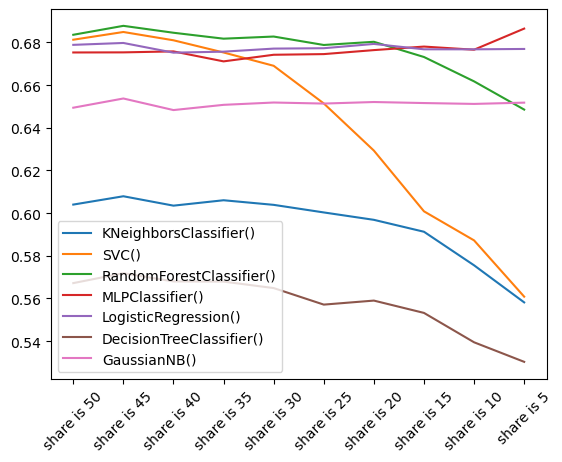

In [45]:
current_plot = []
counter = 0
for model in models:
    current_plot.append([])
#     model = 'KNeighborsClassifier'
    for i in range(len(results_list_2)):
        
#         print(i)
        current_plot[counter].append(results_list_2[i][str(model)[0:str(model).find('(')]])
    
    plt.plot(current_plot[counter])
    counter += 1
#         print(len(current_plot))
    plt.legend(models)
    plt.xticks(range(len(shares)),shares, rotation=45)

In [47]:
df_cut_1 = pd.read_csv('train_data/df_only_last_product_1.csv')
df_cut_1 = df_cut_1.drop(0, axis=0)
df_cut_2 = pd.read_csv('train_data/df_only_last_product_0.csv')
df_cut_2 = df_cut_2.drop(0, axis=0)
df_cut_merged = pd.concat([df_cut_2, df_cut_1], ignore_index=True)
df_cut_merged = df_cut_merged.drop(['id'], axis=1)

In [48]:
model = MLPClassifier()

In [49]:
share = 5
df_cut_merged = sample_df(
    df_cut_merged, 
    round(df_cut_merged.flag.value_counts()[1] / share * 100 + 1, 0),
    100 - share,
    share
)

In [50]:
x = df_cut_merged.drop('flag', axis=1)
y = df_cut_merged.flag

In [55]:
df3 = fastparquet.ParquetFile('train_data/train_data_2.pq').to_pandas()
df3 = pd.merge(df3, answers, on='id', how='left')
df3 = df3.drop(['id'], axis=1)

In [53]:
model.fit(x,y)

MLPClassifier()

In [56]:
x_test = df3.drop('flag', axis=1)
y_test = df3.flag
y_pred_prob = model.predict_proba(x_test)[:, 1]

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.6205342433016622


In [57]:
df_cut_1 = pd.read_csv('train_data/df_only_last_product_1.csv')
df_cut_1 = df_cut_1.drop(0, axis=0)
df_cut_2 = pd.read_csv('train_data/df_only_last_product_0.csv')
df_cut_2 = df_cut_2.drop(0, axis=0)
df_cut_merged = pd.concat([df_cut_2, df_cut_1], ignore_index=True)
df_cut_merged = df_cut_merged.drop(['id'], axis=1)

share = 45
df_cut_merged = sample_df(
    df_cut_merged, 
    round(df_cut_merged.flag.value_counts()[1] / share * 100 + 1, 0),
    100 - share,
    share
)

x = df_cut_merged.drop('flag', axis=1)
y = df_cut_merged.flag

model = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc')
grid_search.fit(x, y)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Best Score: 0.7089107858720117


In [58]:
df_cut_1 = pd.read_csv('train_data/df_only_last_product_1.csv')
df_cut_1 = df_cut_1.drop(0, axis=0)
df_cut_2 = pd.read_csv('train_data/df_only_last_product_0.csv')
df_cut_2 = df_cut_2.drop(0, axis=0)
df_cut_merged = pd.concat([df_cut_2, df_cut_1], ignore_index=True)
df_cut_merged = df_cut_merged.drop(['id'], axis=1)

share = 45
df_cut_merged = sample_df(
    df_cut_merged, 
    round(df_cut_merged.flag.value_counts()[1] / share * 100 + 1, 0),
    100 - share,
    share
)

x = df_cut_merged.drop('flag', axis=1)
y = df_cut_merged.flag

model = MLPClassifier()

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  # Various hidden layer sizes
    'activation': ['relu', 'tanh'],  # Activation functions
    'solver': ['adam', 'sgd'],  # Solvers for weight optimization
    'alpha': [0.0001, 0.001, 0.01],  # L2 penalty (regularization term) parameter
    'learning_rate': ['constant', 'adaptive'],  # Learning rate schedule
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc')
grid_search.fit(x, y)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best Parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
Best Score: 0.6924561066391086


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [59]:
df_cut_1 = pd.read_csv('train_data/df_only_last_product_1.csv')
df_cut_1 = df_cut_1.drop(0, axis=0)
df_cut_2 = pd.read_csv('train_data/df_only_last_product_0.csv')
df_cut_2 = df_cut_2.drop(0, axis=0)
df_cut_merged = pd.concat([df_cut_2, df_cut_1], ignore_index=True)
df_cut_merged = df_cut_merged.drop(['id'], axis=1)

share = 45
df_cut_merged = sample_df(
    df_cut_merged, 
    round(df_cut_merged.flag.value_counts()[1] / share * 100 + 1, 0),
    100 - share,
    share
)


x = df_cut_merged.drop('flag', axis=1)
y = df_cut_merged.flag

model = RandomForestClassifier( n_estimators=200, max_depth=20, min_samples_leaf=4, min_samples_split=10)
model.fit(x,y)

# df3 = df3.drop(['id'], axis=1)

x_test = df3.drop('flag', axis=1)
y_test = df3.flag
y_pred_prob = model.predict_proba(x_test)[:, 1]

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.6366274434843617


In [60]:
df_cut_1 = pd.read_csv('train_data/df_only_last_product_1.csv')
df_cut_1 = df_cut_1.drop(0, axis=0)
df_cut_2 = pd.read_csv('train_data/df_only_last_product_0.csv')
df_cut_2 = df_cut_2.drop(0, axis=0)
df_cut_merged = pd.concat([df_cut_2, df_cut_1], ignore_index=True)
df_cut_merged = df_cut_merged.drop(['id'], axis=1)

share = 45
df_cut_merged = sample_df(
    df_cut_merged, 
    round(df_cut_merged.flag.value_counts()[1] / share * 100 + 1, 0),
    100 - share,
    share
)


x = df_cut_merged.drop('flag', axis=1)
y = df_cut_merged.flag

model = MLPClassifier( activation='relu', alpha=0.01, hidden_layer_sizes=(100,), learning_rate='adaptive', solver='sgd')
model.fit(x,y)

# df3 = df3.drop(['id'], axis=1)

x_test = df3.drop('flag', axis=1)
y_test = df3.flag
y_pred_prob = model.predict_proba(x_test)[:, 1]

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("ROC AUC Score:", roc_auc)

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


ROC AUC Score: 0.6191719974530119


## результат
1) нетюненная модель дает все те же 62 процента на данных из другого чанка - @неудовлетворительно@:(
2) CV на том же чанке дает 68 процентов на разных моделях в зависимости от баланса нулей и единичек в таргете
update
3) оттюненный лес дает на тестовом чанке 0,63, млп так же 0,62

# 4 гиппотеза. Исключать колонки по одной на сбалансированном сете из двух чанков и проверять на третьем

In [67]:
df_cut_1 = pd.read_csv('train_data/df_only_last_product_1.csv')
df_cut_1 = df_cut_1.drop(0, axis=0)
df_cut_2 = pd.read_csv('train_data/df_only_last_product_0.csv')
df_cut_2 = df_cut_2.drop(0, axis=0)
df_cut_merged = pd.concat([df_cut_2, df_cut_1], ignore_index=True)
# df_cut_merged = df_cut_merged.drop(['id'], axis=1)
df3 = fastparquet.ParquetFile('train_data/train_data_2.pq').to_pandas()
df3 = pd.merge(df3, answers, on='id', how='left')

In [68]:
corrs = []
for col in df_cut_merged.columns:
    corrs.append((abs(df_cut_merged['flag'].corr(df_cut_merged[col])), col))
corrs_copy = corrs.copy()    
corrs = sorted(corrs)[:-1]

In [69]:
share = 45
df_cut_merged = sample_df(
    df_cut_merged, 
    round(df_cut_merged.flag.value_counts()[1] / share * 100 + 1, 0),
    100 - share,
    share
)

In [70]:
models = [
    KNeighborsClassifier(),
#     SVC(),
#     RandomForestClassifier(),
#     MLPClassifier(),
#     LogisticRegression(),
#     DecisionTreeClassifier(),
#     GaussianNB(),
]
#     xgb(),
#     lgb(),
# ]

In [72]:
x_uncut = df_cut_merged.drop('flag', axis=1)
y = df_cut_merged.flag
x_test_uncut = df3.drop('flag', axis=1)
y_test = df3.flag


for model in models:
    print(f"model now is {model}")
    cols_to_drop_this_cycle = []
#     counter = 0
    
    for entry in corrs:
        if entry[0] < 0.001:
            cols_to_drop_this_cycle.append(entry[1])


    for entry in corrs:
        if entry[1] in cols_to_drop_this_cycle:
            continue
        
        if len(cols_to_drop_this_cycle) >= 10:
            break

        cols_to_drop_this_cycle.append(entry[1])
        
        x = x_uncut.drop(cols_to_drop_this_cycle, axis=1)
        x_test = x_test_uncut.drop(cols_to_drop_this_cycle, axis=1)
        
        model.fit(x,y)
        



        y_pred_prob = model.predict_proba(x_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        print(f"ROC AUC Score:", roc_auc)
#         print(f"test {len(cols_to_drop_this_cycle)}")
#         counter += 1
    
    

    

model now is KNeighborsClassifier()
ROC AUC Score: 0.5
ROC AUC Score: 0.5


KeyboardInterrupt: 

# результат - явный поворот не туда. 
1) нетюненная модель на сете из двух чанков на третьем тестовом дает аук так же 0,60 - 0,62 - не вижу смысла даже с гридсерчем заморачиваться

# 5 гиппотеза, инжиниринг тайм!

инжиниринг тайм!
1) удалим колонки с "плановыми" значениями 

2) удалим колонки со статусами ежемесячных платежей за последние N месяцев - их много и они бестолковые

3) колонки "нет просрочек более N дней" соберем в одну - чем больше просрочек, тем больше цифра у по клиенту.

4) колонки "число просрочек на N дней" тоже собрем в одну 

5) количество дней с открытия и с даты подтверждения до даты сбора данных тоже долой - не вижу смысловой нагрузки в них долгосрочной в текущей задаче
 
6) напрашивающаяся колонка - если фактическое количество дней pre_fterm меньше планового pre_pterm по закрытию - единичка, ну а если нет - ну.. не единичка:)



In [20]:
df = fastparquet.ParquetFile('train_data/train_data_0.pq').to_pandas()
df = pd.merge(df, answers, on='id', how='left')

In [21]:
cols_to_drop = []
for entry in df.columns:
    if 'enc_paym_' in entry :
        cols_to_drop.append(entry)
        
cols_to_drop = cols_to_drop + ['pre_till_fclose', 'pre_till_pclose', 'pre_since_opened', 'pre_since_confirmed', 'pclose_flag']
    

In [22]:
df['closed_faster_than_expected'] = df['pre_fterm'] < df['pre_pterm'] 
df['closed_faster_than_expected'] = df['closed_faster_than_expected'].apply(lambda x: int(x))

In [25]:
df['overdue_severity'] = 5 - (df['is_zero_loans5'] + df['is_zero_loans530'] + df['is_zero_loans3060'] + df['is_zero_loans6090'] + df['is_zero_loans90']) 

In [26]:
df['prone_to_overdue'] = 0

In [30]:
# Далее первичный код, без использования sql-библиотеки - ооооочень долго. Запускать на свой страх и риск:)

# он в "марке" чтобы не запустить случайно

for entry in df.id.unique():
    df.loc[df.id == entry, 'prone_to_overdue'] = sum(df[df.id == entry]['overdue_severity'])

In [27]:
#далее его новая версия, работает сильно быстрее
    
con = duckdb.connect(':memory:')

# new column, product-wise
df['overdue_severity'] = df['is_zero_loans5'] + df['is_zero_loans530']*2 + df['is_zero_loans3060']*3 + df['is_zero_loans6090']*4 + df['is_zero_loans90']*5

result = con.execute('''
SELECT id, 
cast(SUM(overdue_severity) as float) / max(rn) AS prone_to_overdue
FROM df
GROUP BY id
'''
                    ).fetchall()

result = pd.DataFrame.from_records(result, columns=['id','prone_to_overdue'])
df = pd.merge(result, df, on='id', how='left')


In [28]:
df['prone_to_close_faster'] = 0

In [42]:
# так же беда - очень долгий код, оставляю в марке для истории

for entry in df.id.unique():
    df.loc[df.id == entry, 'prone_to_close_faster'] = sum(df[df.id == entry]['closed_faster_than_expected'])

new_columns = df[['id', 'closed_faster_than_expected', 'prone_to_overdue', 'overdue_severity', 'prone_to_close_faster']]

new_columns.to_csv('train_data/part_0_eng_cols_1')

In [29]:
con = duckdb.connect(':memory:')

# new column, product-wise
df['closed_faster_than_expected'] = df['pre_fterm'] < df['pre_pterm'] 
df['closed_faster_than_expected'] = df['closed_faster_than_expected'].apply(lambda x: int(x))

result = con.execute('''
SELECT id, 
cast(SUM(closed_faster_than_expected) as float) / max(rn) as prone_to_close_faster
FROM df
GROUP BY id
'''
                    ).fetchall()

result = pd.DataFrame.from_records(result, columns=['id', 'prone_to_close_faster'])
df = pd.merge(result, df, on='id', how='left')


In [30]:
df = fastparquet.ParquetFile('train_data/train_data_0.pq').to_pandas()
df = pd.merge(df, answers, on='id', how='left')
df = overdue_and_quick_closure_duck(df)


df2 = fastparquet.ParquetFile('train_data/train_data_0.pq').to_pandas()
df2 = pd.merge(df2, answers, on='id', how='left')
df2 = overdue_and_quick_closure_duck(df2)
# df['flag'] = df['flag_y']
# df = df.drop('flag_y', axis=1)

In [31]:
pos_share = 45
df_cut = sample_df(
    df, 
    round(df.flag.value_counts()[1] / pos_share * 100 + 1, 0),
    100 - pos_share,
    pos_share
)

In [32]:
models = [
#     KNeighborsClassifier(),
#     SVC(),
    RandomForestClassifier(),
    MLPClassifier(),
#     LogisticRegression(),
#     DecisionTreeClassifier(),
    GaussianNB(),
]
#     xgb(),
#     lgb(),
# ]

In [33]:
x = df_cut.drop(cols_to_drop + ['flag'], axis=1)
y = df_cut.flag

In [34]:
results_dict = dict()

In [40]:
for model in models:
    
    cv_scores = cross_val_score(model, x, y, cv=3, scoring='roc_auc')
    results_dict[str(model)[0:str(model).find('(')]] = mean(cv_scores)


In [41]:
results_dict

{'RandomForestClassifier': 0.7113122571123972,
 'MLPClassifier': 0.51348939821603,
 'GaussianNB': 0.6148964537434725}

In [36]:
results_dict = dict()

x_test = df2.drop('flag', axis=1)
y_test = df2.flag

for model in tqdm.tqdm_notebook(models, desc=f"Now {str(model)[0:str(model).find('(')]} working"):
    results_current_model = []
#     for i in range(1):

    x = df_cut.drop('flag', axis=1)
    y = df_cut.flag

    model.fit(x,y)

    y_pred_prob = model.predict_proba(x_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred_prob)

    results_current_model.append(roc_auc)
        
    results_dict[str(model)[0:str(model).find('(')]] = results_current_model[0]
results_dict

C:\Users\User\AppData\Local\Temp\ipykernel_12784\927631884.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for model in tqdm.tqdm_notebook(models, desc=f"Now {str(model)[0:str(model).find('(')]} working"):


Now RandomForestClassifier working:   0%|          | 0/3 [00:00<?, ?it/s]

{'RandomForestClassifier': 0.9926871733536528,
 'MLPClassifier': 0.5285025487207592,
 'GaussianNB': 0.6106061630213018}

In [37]:
share = 45
df_cut_2 = sample_df(
    df2, 
    round(df.flag.value_counts()[1] / share * 100 + 1, 0),
    100 - share,
    share
)

In [38]:
x = df_cut_2.drop(cols_to_drop + ['flag'], axis=1)
y = df_cut_2.flag

In [39]:
results_dict = dict()

In [40]:
for model in models:
    
    cv_scores = cross_val_score(model, x, y, cv=3, scoring='roc_auc')
    results_dict[str(model)[0:str(model).find('(')]] = mean(cv_scores)


In [41]:
results_dict

{'RandomForestClassifier': 0.7101708991792263,
 'MLPClassifier': 0.5164326825368776,
 'GaussianNB': 0.6122935293058482}

# результат
вообще непонятно!
проверял на двух кусках - на одном лес дал 0,7, остальные ничего особенного

в теории инжиниринг имеет место быть, но нужно больше

# 7 гиппотеза. голосование моделей. попробуем на сете сразу из трех чанков.

порядок работы в этой гиппотезе такой:
1) раз делать хотим из 3х чанков - нужен 4й для валидации. распакуем спарком еще кусок данных в цсв
2) делаем сбалансированный сет из трех чанков, валидируем CV-шкой, записываем 3 лучшие модели (или 2?) и результаты
2.1) а вот вопрос - как делать голосование - большинством (и тогда 3 модели) или по большей вероятности? (и тогда 2 модели)
2.2) валидируем вручную на трейне, 3 прогона, среднее, записываем
3) валидируем на тесте (сет из 4-го куска данных (боже как я ненавиижу слово "чанк" в переложении на русский) человека, который придумал ввести его в обиход в траскрипции без изменений нужно насильно отлучить от русского!)
3) так вот. записываем результаты по каждой модели
4) валидируем на трейне большинством
5) валидируем на трейне по большей вероятности
6) валидируем на тесте большинством
7) валидируем на тесте по большей вероятности
8) расстраиваемся, что опять нифига не получилось

In [44]:
df = fastparquet.ParquetFile('train_data/train_data_0.pq').to_pandas()
df = answers_func(df)
df2 = fastparquet.ParquetFile('train_data/train_data_1.pq').to_pandas()
df2 = answers_func(df2)
df3 = fastparquet.ParquetFile('train_data/train_data_2.pq').to_pandas()
df3 = answers_func(df3)

In [45]:
share = 45

df_cut_1 = sample_df(
    df, 
    round(df.flag.value_counts()[1] / share * 100 + 1, 0),
    100 - share,
    share
)

df_cut_2 = sample_df(
    df2, 
    round(df2.flag.value_counts()[1] / share * 100 + 1, 0),
    100 - share,
    share
)

df_cut_3 = sample_df(
    df3, 
    round(df3.flag.value_counts()[1] / share * 100 + 1, 0),
    100 - share,
    share
)

df = None
df2 = None
df3 = None

In [46]:
df_cut_merged = pd.concat([df_cut_1, df_cut_2, df_cut_3], ignore_index=True)


In [50]:
df_cut_merged.flag.value_counts()

flag
0    110000
1     90000
Name: count, dtype: int64

In [51]:
models = [
#     KNeighborsClassifier(),
#     SVC(),
    RandomForestClassifier(),
    MLPClassifier(),
#     LogisticRegression(),
#     DecisionTreeClassifier(),
    GaussianNB(),
]
#     xgb(),
#     lgb(),
# ]

In [52]:
df_cut_merged = sample_df(df_cut_merged, 200000, 55, 45)

In [53]:
x = df_cut_merged.drop('flag', axis=1)
y = df_cut_merged.flag

In [31]:
results_dict = dict()

In [55]:
df = fastparquet.ParquetFile('train_data/train_data_0.pq').to_pandas()
df = answers_func(df)
df2 = fastparquet.ParquetFile('train_data/train_data_1.pq').to_pandas()
df2 = answers_func(df2)

share = 45

df_cut_1 = sample_df(
    df, 
    round(df.flag.value_counts()[1] / share * 100 + 1, 0),
    100 - share,
    share
)

df_cut_2 = sample_df(
    df2, 
    round(df2.flag.value_counts()[1] / share * 100 + 1, 0),
    100 - share,
    share
)

df_cut_merged = pd.concat([df_cut_1, df_cut_2], ignore_index=True)
df3 = fastparquet.ParquetFile('train_data/train_data_2.pq').to_pandas()
df3 = answers_func(df3)

In [56]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

In [57]:
x = df_cut_merged.drop('flag', axis=1)
y = df_cut_merged.flag

In [64]:
x_test = df3.drop('flag', axis=1)
y_test = df3.flag

for model in tqdm.tqdm_notebook(models, desc=f'now working {model}'):
    model.fit(x,y)
#     y_pred = model.predict(x_test)
    
    print( roc_auc_scorer(model, x_test, y_test))

    

C:\Users\User\AppData\Local\Temp\ipykernel_12784\2324247700.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for model in tqdm.tqdm_notebook(models, desc=f'now working {model}'):


now working RandomForestClassifier():   0%|          | 0/3 [00:00<?, ?it/s]

0.6263367989965528
0.5
0.5813534738284672


In [67]:
models[0].predict_proba(x_test)

KeyboardInterrupt: 

In [32]:
for model in models:
    
    cv_scores = cross_val_score(model, x, y, cv=3, scoring='roc_auc')
    results_dict[str(model)[0:str(model).find('(')]] = mean(cv_scores)


In [33]:
results_dict

{'RandomForestClassifier': 0.648269512629804,
 'MLPClassifier': 0.5503701670373317,
 'GaussianNB': 0.5805406732383585}

# результат
да не особо то помогает
в теории можно попробовать поиграть порогами значений, но не уверен, насколько это поможет

# гиппотеза 12 разобраться с бустингом

In [31]:


# Load the Iris dataset (a sample classification dataset)
df2 = pd.read_csv('train_data/df_only_last_product_0.csv')
X, y = df2.drop('flag', axis=1), df2.flag

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and train the XGBoost classifier
model = xgb.XGBClassifier(objective='multi:softmax', num_class=2, max_depth=3, learning_rate=0.1, n_estimators=100)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
roc = roc_auc_score(y_test, y_pred)
print('roc ', roc)

roc  0.5


In [30]:
df = pd.read_csv('train_data/df_only_last_product_1.csv')
X_test, y_test = df.drop('flag', axis=1), df.flag

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
roc = roc_auc_score(y_test, y_pred)
print('roc ', roc)

roc  0.5


Index(['id', 'rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
       'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
       'pre_loans_outstanding', 'pre_loans_total_overdue',
       'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5',
       'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
       'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
       'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit',
       'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit',
       'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2',
       'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
       'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12',
       'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16',
       'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20',
       'enc_paym_21', 

In [53]:
df = pd.read_csv('train_data/part_0_eng_cols_1')
df = df.drop('Unnamed: 0', axis=1)
df = pd.merge(df, answers, on='id', how='left')

share = 45
df = sample_df(
    df, 
    round(df.flag.value_counts()[1] / share * 100 + 1, 0),
    100 - share,
    share
)




In [54]:
df2 = pd.read_csv('train_data/part_1_eng_cols_1')
df2 = df2.drop('Unnamed: 0', axis=1)
df2 = pd.merge(df2, answers, on='id', how='left')
df2['flag'] = df2['flag_y']
df2 = df2.drop(['flag_y', 'flag_x'], axis=1)

In [52]:
df.shape

(126902, 66)

In [62]:
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer

# Load the Iris dataset (a sample classification dataset)
# df2 = pd.read_csv('train_data/df_only_last_product_0.csv')
X, y = df2.drop('flag', axis=1), df2.flag

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost classifier
model = xgb.XGBClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
}

# Define ROC AUC as the scoring metric for GridSearchCV
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

# Perform GridSearchCV with ROC AUC as the scoring metric
grid_search = GridSearchCV(model, param_grid, cv=3, scoring=roc_auc_scorer)
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_proba = best_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1], multi_class='ovr')
print('Best Model ROC AUC:', roc_auc)
print('Best params:', grid_search.best_params_)

Best Model ROC AUC: 0.7751645876217838
Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [63]:
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer

# Load the Iris dataset (a sample classification dataset)
# df2 = pd.read_csv('train_data/df_only_last_product_1.csv')
X, y = df.drop('flag', axis=1), df.flag

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost classifier
model = xgb.XGBClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
}

# Define ROC AUC as the scoring metric for GridSearchCV
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

# Perform GridSearchCV with ROC AUC as the scoring metric
grid_search = GridSearchCV(model, param_grid, cv=3, scoring=roc_auc_scorer)
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_proba = best_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1], multi_class='ovr')
print('Best Model ROC AUC:', roc_auc)
print('Best params:', grid_search.best_params_)

Best Model ROC AUC: 0.7693579526356988
Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


# результат
1) well ill be damned - consistent satisfactory metric on single chunks with minimal feature engeneering
2) looks like its time to move to stage 2
